# 1

In [1]:
import torch
import numpy as np

## GPU

Jednym z kluczowych udogodnień pytorcha jest możliwość szybkiego i prostego przenoszenia obliczeń między CPU a GPU

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda")
device

device(type='cuda')

In [4]:
x = torch.zeros(2, 3)
print("X", x)
x = x.to(device)
print("X", x)

X tensor([[0., 0., 0.],
        [0., 0., 0.]])
X tensor([[0., 0., 0.],
        [0., 0., 0.]], device='cuda:0')


#### Ciąg komend do zapisania
Losowość jest bardzo ważnym elementem trenowania sieci neuronowych (o czym się wkrótce przekonamy). Eksperymentując, chcielibyśmy jednak żeby przy każdym uruchomieniu programu, wynik był taki sam. Tylko w takim przypadku jesteśmy w stanie coś wnioskować. Do zapewnienia możliwości reprodukcji wyników na GPU za pomocą pytorcha służa poniższe komendy:

In [5]:
# GPU operations have a separate seed we also want to set
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

## Tworzenie modeli
Tworzymy tensory z parametrami, wagi i biasy, obliczamy gradienty, aktualizujemy parametry itd.
lub
wykorzystujemy torch.nn

W torch.nn możemy znaleźć wiele przydatnych predefiniowanych klas jak wagi sieci, funkcje aktywacji, funkcje straty, optymalizacja itp. Jeszcze raz, dokumentacja jest fajna: https://pytorch.org/docs/stable/nn.html

In [6]:
import torch.nn as nn

Dodatkowo, funkcje wykorzystywane w budowaniu sieci znajdują się w module torch.nn.functionl

In [7]:
import torch.nn.functional as F

### nn.Module
W PyTorchu, sieci neuronowe są zbudowane z modułów - obiektów klas dziedziczących po klasie nn.Module. Moduły mogą składać się z innych modułów, a sieć neuronowa w całości też zazwyczaj jest modułem.

Podstawowy template dla modułu wygląda następująco

In [8]:
class MyModule(nn.Module):

    def __init__(self):
        super().__init__()
        # Some init for my module

    def forward(self, x):
        # Function for performing the calculation of the module.
        pass

W konstruktorze modułu zazwyczaj inicjowane są wszystkie parametry, lub wewnętrzne moduły (np. warstwy sieci)

W funkcji forward zapisane są wszystkie obliczenia które są wykonywane kiedy wywołujemy dany moduł. Przykładowo: (nn = MyModule(); nn(x)).

Kalkulacja wstecz (backwards) jest tworzona automatycznie, ale w razie potrzeby można ją też nadpisywać

# Stwórzmy pierwsza sieć neuronową

In [9]:
class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        # Initialize the modules we need to build the network
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)
#         self.linear3 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
#         x = self.act_fn(x)
#         x = self.linear3(x)
        return x

Wypisywanie zawartości modelu

In [10]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
model.cuda()
# Printing a module shows all its submodules
print(model)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)


In [11]:
x = torch.Tensor(2).cuda()

In [12]:
model.forward(x)
model(x)

tensor([-0.5242], device='cuda:0', grad_fn=<ViewBackward0>)

Co tak właściwie mamy w środku?

In [13]:
for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

Parameter linear1.weight, shape torch.Size([4, 2])
Parameter linear1.bias, shape torch.Size([4])
Parameter linear2.weight, shape torch.Size([1, 4])
Parameter linear2.bias, shape torch.Size([1])


## Activation functions

In [14]:
# act_fn_by_name = {
#     "sigmoid": torch.sigmoid,
#     "tanh": torch.tanh,
#     "relu": F.relu,
#     "leakyrelu": F.leaky_relu
# }

In [15]:
# def get_grads(act_fn, x):
#     x = x.clone().requires_grad_() # Mark the input as tensor for which we want to store gradients
#     out = act_fn(x)
#     out.sum().backward() # Summing results in an equal gradient flow to each element in x
#     return x.grad # Accessing the gradients of x by "x.grad"

In [16]:
# %matplotlib inline
# def vis_act_fn(act_fn, name, ax, x):
#     # Run activation function
#     y = act_fn(x)
#     y_grads = get_grads(act_fn, x)
#     # Push x, y and gradients back to cpu for plotting
#     x, y, y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy()
#     ## Plotting
#     ax.plot(x, y, linewidth=2, label="ActFn")
#     ax.plot(x, y_grads, linewidth=2, label="Gradient")
#     ax.set_title(name)
#     ax.legend()
#     ax.set_ylim(-1.5, x.max())
# 
# x = torch.linspace(-5, 5, 1000) # Range on which we want to visualize the activation functions
# ## Plotting
# rows = math.ceil(len(act_fn_by_name)/2.0)
# fig, ax = plt.subplots(rows, 2, figsize=(8, rows*4))
# for i, name in enumerate(act_fn_by_name.keys()):
#     vis_act_fn(act_fn_by_name[name], name, ax[divmod(i,2)], x)
# fig.subplots_adjust(hspace=0.3)
# plt.show()
# plt.close()

# Dane
PyTorch posiada zaimplementowanych kilka funkcjonalności które pozwalają wczytywać i manipulować danymi. Znajdują się one w pakiecie torch.utils.data

In [17]:
import torch.utils.data as data

Główną strukturą w ramach której przechowywane (lub niekoniecznie) są dane jest klasa Dataset. Stwórzmy sobie przykładowy zbiór danych - tzw. ciągły XOR. Przykład zaczerpnięty z https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.html#Learning-by-example:-Continuous-XOR

In [18]:
class XORDataset(data.Dataset):

    def __init__(self, size, std=0.1):
        """
        Inputs:
            size - Number of data points we want to generate
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.std * torch.randn(data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

In [19]:
dataset = XORDataset(size=200)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (tensor([-0.0563, -0.0947]), tensor(0))


In [20]:
# examples = dataset.data
# labels = dataset.label
# data_0 = examples[labels == 0]
# data_1 = examples[labels == 1]
# 
# plt.figure(figsize=(4,4))
# plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
# plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
# plt.title("Dataset samples")
# plt.legend()
# plt.show()

## Data loaders (Ładowacze danych?!)

In [21]:
data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True)

In [22]:
next(iter(data_loader))

[tensor([[ 0.9452,  0.1674],
         [-0.2069, -0.0391],
         [ 1.0049,  0.9820],
         [ 1.0657,  1.0005],
         [ 1.0438,  0.9869],
         [ 0.9118,  1.0964],
         [ 0.9649, -0.1308],
         [-0.0044,  0.1793]]),
 tensor([1, 0, 0, 0, 0, 0, 1, 0])]

In [23]:
len(data_loader)

25

In [24]:
next(iter(data_loader))[0].shape[0]*len(data_loader)

200

In [25]:
data_loader_2 = data.DataLoader(dataset, batch_size=7, shuffle=True)
next(iter(data_loader_2))[0].shape[0]*len(data_loader_2)

203

In [26]:
list(iter(data_loader_2))[-1]

[tensor([[ 1.0054, -0.0045],
         [ 0.9967,  0.9780],
         [-0.1983,  0.0554],
         [ 1.0064,  0.9861]]),
 tensor([1, 0, 0, 0])]

#### Drop last
Parametr powodujący pominięcie ostatniego wsadu (batch)

In [27]:
data_loader_2 = data.DataLoader(dataset,batch_size=7, shuffle=True, drop_last=True)
next(iter(data_loader_2))[0].shape[0]*len(data_loader_2)

196

## Funkcje straty
Na poprzednich zajęciach obliczaliśmy funkcję straty ręcznie wykonując operacje na tensorach. Jest to w pełni poprawne rozwiązanie, ale możemy też nie wymyślać koła na nowo, ale wykorzystać wbudowane moduły. Pełna lista dostępna tutaj: https://pytorch.org/docs/stable/nn.html#loss-functions

In [28]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
tensor_1 = torch.arange(5)
tensor_2 = torch.ones(5)
print(tensor_1, tensor_2)

tensor([0, 1, 2, 3, 4]) tensor([1., 1., 1., 1., 1.])


### Błąd średniokwadratowy (Mean Squared Error) lub L2Loss

In [30]:
loss = nn.MSELoss()
loss(tensor_1,tensor_2)

tensor(3.)

$ \quad l_{n}=\left(x_{n}-y_{n}\right)^{2}$

In [31]:
loss = nn.MSELoss(reduction="none")
print(f"No reduction: {loss(tensor_1,tensor_2)}")
loss = nn.MSELoss(reduction="mean")
print(f"Mean: {loss(tensor_1,tensor_2)}")
loss = nn.MSELoss(reduction="sum")
print(f"Sum: {loss(tensor_1,tensor_2)}")

No reduction: tensor([1., 0., 1., 4., 9.])
Mean: 3.0
Sum: 15.0


In [32]:
F.mse_loss(tensor_1, tensor_2)

tensor(3.)

/home/tomek/miniconda3/envs/cw1_pd/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025842427/work/aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


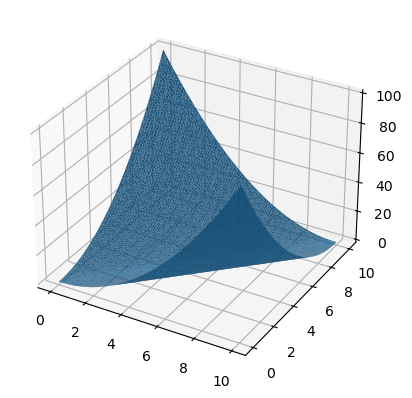

In [33]:
loss = nn.MSELoss(reduction="none")
x, y = torch.meshgrid(torch.linspace(0,10,100),torch.linspace(0,10,100))
z = loss(x,y)

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
#ax = fig.gca(projection='3d') - for older matplotlib

ax.plot_trisurf(x.numpy().flatten(), y.numpy().flatten(), z.numpy().flatten(), linewidth=0.2, antialiased=True)

plt.show()

### Błąd bezwzględny (Mean absolute Error) lub L1Loss

$ \quad l_{n}=\left|x_{n}-y_{n}\right|$

In [34]:
print(tensor_1, tensor_2)
loss = nn.L1Loss()
loss(tensor_1,tensor_2)

tensor([0, 1, 2, 3, 4]) tensor([1., 1., 1., 1., 1.])


tensor(1.4000)

In [35]:
loss = nn.L1Loss(reduction="none")
print(f"No reduction: {loss(tensor_1,tensor_2)}")
loss = nn.L1Loss(reduction="mean")
print(f"Mean: {loss(tensor_1,tensor_2)}")
loss = nn.L1Loss(reduction="sum")
print(f"Sum: {loss(tensor_1,tensor_2)}")

No reduction: tensor([1., 0., 1., 2., 3.])
Mean: 1.399999976158142
Sum: 7.0


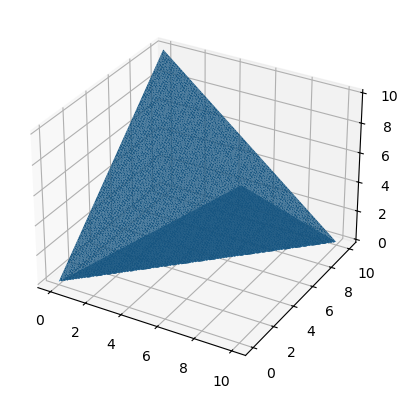

In [36]:
loss = nn.L1Loss(reduction="none")
x, y = torch.meshgrid(torch.linspace(0,10,100),torch.linspace(0,10,100))
z = loss(x,y)

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
#ax = fig.gca(projection='3d') - for older matplotlib

ax.plot_trisurf(x.numpy().flatten(), y.numpy().flatten(), z.numpy().flatten(), linewidth=0.2, antialiased=True)

plt.show()

### Entropia krzyżowa:
$l_{n}=\left[y_{n} \cdot \log x_{n}+\left(1-y_{n}\right) \cdot \log \left(1-x_{n}\right)\right]$

In [37]:
tensor_1 = torch.rand(5)
tensor_2 = torch.ones(5)
print(tensor_1, tensor_2)
loss = nn.BCELoss(reduction="none")
loss(tensor_1,tensor_2)

tensor([0.8555, 0.6560, 0.0249, 0.3741, 0.0382]) tensor([1., 1., 1., 1., 1.])


tensor([0.1560, 0.4216, 3.6940, 0.9832, 3.2641])

In [38]:
# loss(tensor_1*10,tensor_2)

In [39]:
loss = nn.BCEWithLogitsLoss(reduction="none")
loss(tensor_1*100,tensor_2)

tensor([0.0000, 0.0000, 0.0799, 0.0000, 0.0216])

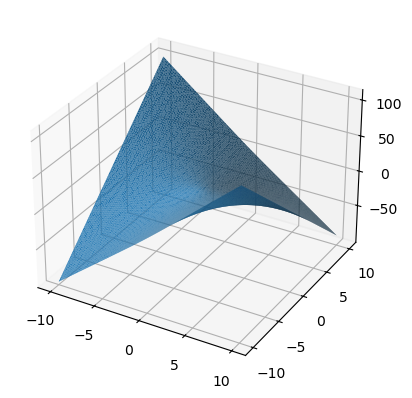

In [40]:
loss = nn.BCEWithLogitsLoss(reduction="none")
x, y = torch.meshgrid(torch.linspace(-10,10,100),torch.linspace(-10,10,100))
z = loss(x,y)

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
#ax = fig.gca(projection='3d') - for older matplotlib

ax.plot_trisurf(x.numpy().flatten(), y.numpy().flatten(), z.numpy().flatten(), linewidth=0.2, antialiased=True)

plt.show()

# Optymalizacja parametrów
W przykładowym problemie optymalizacji parametrów regresji, ręcznie aktualizowaliśmy gradienty. W torch są do tego narzędzia zwane optymalizatorami, znajdują się one w pakiecie torch.optim

Najprostszym optymalizaotrem jest algorytm stochastycznego spadku gradientu (Stochastic Gradient Descent) - SGD

In [41]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
print(model)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)


In [42]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

## Połączmy to wszystko razem

In [43]:
train_dataset = XORDataset(size=1000)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [44]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
model.to(device)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)

In [45]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

In [46]:
loss_module = nn.BCEWithLogitsLoss()

In [47]:
model.train()

# Training loop
for epoch in range(100):
    for data_inputs, data_labels in train_data_loader:

        ## Step 1: Move input data to device (only strictly necessary if we use GPU)
        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)

        ## Step 2: Run the model on the input data
        preds = model(data_inputs)
        preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

        ## Step 3: Calculate the loss
        loss = loss_module(preds, data_labels.float())

        ## Step 4: Perform backpropagation
        # Before calculating the gradients, we need to ensure that they are all zero.
        # The gradients would not be overwritten, but actually added to the existing ones.
        optimizer.zero_grad()
        # Perform backpropagation
        loss.backward()

        ## Step 5: Update the parameters
        optimizer.step()
    print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 0.666
Epoch: 1, loss: 0.689
Epoch: 2, loss: 0.697
Epoch: 3, loss: 0.698
Epoch: 4, loss: 0.702
Epoch: 5, loss: 0.692
Epoch: 6, loss: 0.69
Epoch: 7, loss: 0.68
Epoch: 8, loss: 0.68
Epoch: 9, loss: 0.685
Epoch: 10, loss: 0.703
Epoch: 11, loss: 0.695
Epoch: 12, loss: 0.695
Epoch: 13, loss: 0.681
Epoch: 14, loss: 0.69
Epoch: 15, loss: 0.689
Epoch: 16, loss: 0.688
Epoch: 17, loss: 0.687
Epoch: 18, loss: 0.683
Epoch: 19, loss: 0.684
Epoch: 20, loss: 0.686
Epoch: 21, loss: 0.69
Epoch: 22, loss: 0.69
Epoch: 23, loss: 0.678
Epoch: 24, loss: 0.668
Epoch: 25, loss: 0.677
Epoch: 26, loss: 0.673
Epoch: 27, loss: 0.677
Epoch: 28, loss: 0.675
Epoch: 29, loss: 0.661
Epoch: 30, loss: 0.679
Epoch: 31, loss: 0.675
Epoch: 32, loss: 0.663
Epoch: 33, loss: 0.665
Epoch: 34, loss: 0.663
Epoch: 35, loss: 0.663
Epoch: 36, loss: 0.662
Epoch: 37, loss: 0.671
Epoch: 38, loss: 0.666
Epoch: 39, loss: 0.655
Epoch: 40, loss: 0.662
Epoch: 41, loss: 0.66
Epoch: 42, loss: 0.648
Epoch: 43, loss: 0.647
Epoch

### Ewaluacja

In [48]:
test_dataset = XORDataset(size=500)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)

In [49]:
model.eval() # Set model to eval mode
true_preds, num_preds = 0., 0.

with torch.no_grad(): # Deactivate gradients for the following code
    for data_inputs, data_labels in test_data_loader:

        # Determine prediction of model on dev set
        data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
        preds = model(data_inputs)
        preds = preds.squeeze(dim=1)
        preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
        pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1

        # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
        true_preds += (pred_labels == data_labels).sum()
        num_preds += data_labels.shape[0]

acc = true_preds / num_preds
print(f"Accuracy of the model: {100.0*acc:4.2f}%")

Accuracy of the model: 100.00%


In [50]:
from matplotlib.colors import to_rgba

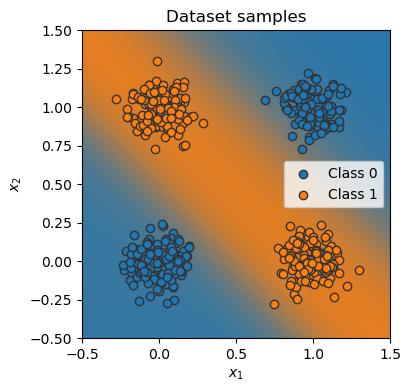

In [51]:
%matplotlib inline
with torch.no_grad():
    data = test_dataset.data.cpu().numpy()
    label = test_dataset.label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    # Let's make use of a lot of operations we have learned above
    model.to(device)
    c0 = torch.Tensor(to_rgba("C0")).to(device)
    c1 = torch.Tensor(to_rgba("C1")).to(device)
    x1 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2) # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)
    preds = torch.sigmoid(preds)
    output_image = preds * c0[None,None] + (1 - preds) * c1[None,None] # Specifying "None" in a dimension creates a new one
    output_image = output_image.cpu().numpy() # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='upper', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)

## Zapisywanie i wczytywanie modelu

In [52]:
model = model.to(device)
state_dict = model.state_dict()
print(state_dict)

OrderedDict([('linear1.weight', tensor([[ 1.1429, -1.1603],
        [ 2.3277, -2.4591],
        [-1.8085,  1.6200],
        [ 0.2547,  0.4733]], device='cuda:0')), ('linear1.bias', tensor([ 0.6362, -1.1918, -0.8062,  0.7579], device='cuda:0')), ('linear2.weight', tensor([[-1.1172,  2.8089,  1.9969,  1.0580]], device='cuda:0')), ('linear2.bias', tensor([1.7197], device='cuda:0'))])


In [53]:
model = model.to(device)
torch.save(state_dict, "simple_model.tar")

In [54]:
torch.save(model,"test")

In [55]:
# Load state dict from the disk (make sure it is the same name as above)
state_dict = torch.load("simple_model.tar")

# Create a new model and load the state
new_model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1).to(device)
new_model.load_state_dict(state_dict)
# Verify that the parameters are the same
print("Original model\n", model.state_dict())
print("\nLoaded model\n", new_model.state_dict())

Original model
 OrderedDict([('linear1.weight', tensor([[ 1.1429, -1.1603],
        [ 2.3277, -2.4591],
        [-1.8085,  1.6200],
        [ 0.2547,  0.4733]], device='cuda:0')), ('linear1.bias', tensor([ 0.6362, -1.1918, -0.8062,  0.7579], device='cuda:0')), ('linear2.weight', tensor([[-1.1172,  2.8089,  1.9969,  1.0580]], device='cuda:0')), ('linear2.bias', tensor([1.7197], device='cuda:0'))])

Loaded model
 OrderedDict([('linear1.weight', tensor([[ 1.1429, -1.1603],
        [ 2.3277, -2.4591],
        [-1.8085,  1.6200],
        [ 0.2547,  0.4733]], device='cuda:0')), ('linear1.bias', tensor([ 0.6362, -1.1918, -0.8062,  0.7579], device='cuda:0')), ('linear2.weight', tensor([[-1.1172,  2.8089,  1.9969,  1.0580]], device='cuda:0')), ('linear2.bias', tensor([1.7197], device='cuda:0'))])


## Zrób to sam. Polecane przećwiczyć przed kolejnymi ćwiczeniami.

Spróbujmy przewidzieć ocenę wina na podstawie jego parametrów

In [56]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', delimiter=";")

In [57]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


#### ... Jakieś wstępne przetwarzanie danych?

In [58]:
train=df.sample(frac=0.8,random_state=200) #random state is a seed value
test=df.drop(train.index)

In [59]:
import torch.utils.data as data

In [60]:
train_dataset = data.TensorDataset(torch.from_numpy(train.values[:,:-1]),torch.from_numpy(train.values[:,-1]))
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [105]:
# class P1Net(nn.Module):
# 
#     def __init__(self, num_inputs, num_hidden, num_outputs):
#         super().__init__()
#         # Initialize the modules we need to build the network
#         self.linear1 = nn.Linear(num_inputs, num_hidden)
#         self.linear2 = nn.Linear(num_hidden, num_hidden)
#         self.linear3 = nn.Linear(num_hidden, num_hidden)
#         self.linear4 = nn.Linear(num_hidden, num_outputs)
#         self.act_fn = nn.ReLU()
# 
#     def forward(self, x):
#         # Perform the calculation of the model to determine the prediction
#         x = self.linear1(x)
#         x = self.act_fn(x)
#         x = self.linear2(x)
#         x = self.act_fn(x)
#         x = self.linear3(x)
#         x = self.act_fn(x)
#         x = self.linear4(x)
#         return x
# 
# model = P1Net(num_inputs=11, num_hidden=128, num_outputs=13)


model = SimpleClassifier(num_inputs=11, num_hidden=32, num_outputs=1)
model.to(device)

SimpleClassifier(
  (linear1): Linear(in_features=11, out_features=32, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=32, out_features=1, bias=True)
)

In [106]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [107]:
loss_module = nn.MSELoss()

In [108]:
model.train()

# Training loop
for epoch in range(200):
    for X, y in train_data_loader:

        ## Step 1: Move input data to device (only strictly necessary if we use GPU)
        X = X.float().to(device)
        # y = y.float().to(torch.int64).to(device)
        y = y.float().to(device)

        ## Step 2: Run the model on the input data
        preds = model(X).squeeze(dim=1).float() # Output is [Batch size, 1], but we want [Batch size]

        ## Step 3: Calculate the loss
        loss = loss_module(preds, y)

        ## Step 4: Perform backpropagation
        # Before calculating the gradients, we need to ensure that they are all zero.
        # The gradients would not be overwritten, but actually added to the existing ones.
        optimizer.zero_grad()
        # Perform backpropagation
        loss.backward()

        ## Step 5: Update the parameters
        optimizer.step()
    if epoch % 25 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 32.6
Epoch: 25, loss: 7.89
Epoch: 50, loss: 1.89
Epoch: 75, loss: 0.663
Epoch: 100, loss: 0.928
Epoch: 125, loss: 0.657
Epoch: 150, loss: 0.638
Epoch: 175, loss: 0.573
